# Pset on quasi experimental methods

[Download notebook :fontawesome-solid-download:](../hw-quasi.ipynb){: .md-button .md-button--primary download="hw-quasi.ipynb"}

In this problem set we are going to make use of `pandas` to analyze the effect of a fictuous experiment I have added to a data set. The data will be using is the sample data provided by Yelp. The goal is to familiarize ourselves with working with such datasets.

The original data is available here: [Yelp data](https://www.yelp.com/dataset/download).
However for this homework you will have to use the data I constructed from the original sample. You can download such file here: 

 - **homework data**: [hw-yelp.tar.gz](http://econ21340.lamadon.com/hw-yelp.tar.gz) (~2.6Go)

Note that on windows you can use [7zip](https://www.7-zip.org/download.html) to uncompress that file. On OSX and linux you can simply use `tar -cxvf hw-yelp.tar.gz`

In the data I have introduced an experiment. The back sotry is that Yelp rolled out a new interface for a randomly select group of users. These uses were randomly selected among users that posted a review in the month of January 2010. The `id` of these users in listed in the `yelp_academic_dataset_review_treatment.json` file present in the archive.

For this group of user a the new website interface was put in place on February 1st 2010. As a Yelp employee you are asked to analyze the impact of a new app. The company is interested in the effect on user engagement which is measured by rating activity. We will focus on the number of ratings.

In this homework we will cover:
 1. loading large data using streaming/chunks, learn about json
 - working with date in pandas
 - analyze randomly assigned treatment
 - construct comparable control group
 - analyze at the level of randomization
 
some useufl links:
 - [tutorial on dates in pandas](https://pbpython.com/pandas-grouper-agg.html)
 - [pandas documentation on reshaping](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html)
 - [yelp data documentation](https://www.yelp.com/dataset/documentation/main)

We start with a simple list of imports, as well as defining the path to the file we will be using. Please update the paths to point to the correct location on your computer.

In [1]:
import os
import pandas as pd
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

file_review = os.path.expanduser("~/Downloads/hw-yelp/yelp_academic_dataset_review_experiment.json")
file_treatment = os.path.expanduser("~/Downloads/hw-yelp/yelp_academic_dataset_review_treatment.json")

def file_len(fname):
    """ Function which efficiently computes the number of lines in file"""
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1


You are already familiar with the following section, this is the code that loads my solution. Since you don't have the file, this part of the code won't work for you. 

In [2]:
%cd ..
%load_ext autoreload
%autoreload 2
#import solutions.sol_pset3 as solution you need to command this, you don't have the solution file!

/Users



# Loading the yelp review data

The data is stored in `json` format. This is a widely used format to store structured data. See [here](https://www.w3schools.com/python/python_json.asp) for working with json in general in python.

The data itself is quite large, hence we are going to use the `chunksize` argument of the `read_json` function of `pandas`. You can of course try for your self to directly load the data by using `pd.read_json(file_review)`, this however might take a while!

In the following section I provide a code example that loads the business information using chunks of size `100,000`. The code **contains a few errors**. Use the data documentation (using the link in the intro) to fix the code a load the data. The code also drops variables which will be very needed and keep some others that are just going to clutter your computer memory. Again, look at the documentation and at the questions ahead to keep the right set of variables.


Note how the code first compute the length of the file 

```python
size = 100000
review = pd.read_json(filepath, lines=True,
                      dtype={'review_id':str,
                             'user_id':float,
                             'business_id':str,
                             'stars':int,
                             'date':str,
                             'text':float,
                             'useful':int,
                             'funny':str,
                             'cool':int},
                      chunksize=size)

chunk_list = []
for chunk_review in tqdm.tqdm(review,total=  np.ceil(file_len(filepath)/size )  ):
    # Drop columns that aren't needed
    chunk_review = chunk_review.drop(['review_id','date'], axis=1)
    chunk_list.append(chunk_review)

df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
```

The following runs my version of the code, it takes around 2 minutes on my laptop. I show you a few of the columns that I chose to extract. In particular, you can check that you get the right row count of `7998013`. 

In [3]:
#Answer to question 1 - loading the data

def question1(filepath):
    '''
    Takes json filepath and returns dataframe with appropriate columns. 
    '''
    size = 100000
    review = pd.read_json(filepath, lines=True,
                      dtype={'review_id':str,
                             'user_id':float,
                             'business_id':str,
                             'stars':int,
                             'date':str,
                             'text':float,
                             'useful':int,
                             'funny':str,
                             'cool':int},
                      chunksize=size)

    chunk_list = []
    for chunk_review in tqdm.tqdm(review,total=  np.ceil(file_len(filepath)/size )  ):
        # Drop columns that aren't needed 
        chunk_review = chunk_review.drop(['business_id', 'stars','text','useful','funny','cool'], axis=1)
        chunk_list.append(chunk_review)
        df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
        
    return df

In [4]:
df_review = question1(file_review)
df_review['date'] = pd.to_datetime(df_review.date) # convert the date string to an actual date
df_review[['review_id','user_id','date']]

100%|██████████| 80/80.0 [08:24<00:00,  6.31s/it]


,review_id,user_id,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,2017-01-14 21:56:57
...,...,...,...
7998008,LAzw2u1ucY722ryLEXHdgg,6DMFD3BRp-MVzDQelRx5UQ,2019-12-11 01:07:06
7998009,gMDU14Fa_DVIcPvsKtubJA,_g6P8H3-qfbz1FxbffS68g,2019-12-10 04:15:00
7998010,EcY_p50zPIQ2R6rf6-5CjA,Scmyz7MK4TbXXYcaLZxIxQ,2019-06-06 15:01:53
7998011,-z_MM0pAf9RtZbyPlphTlA,lBuAACBEThaQHQGMzAlKpg,2018-07-05 18:45:21


# Our first plot of the data

Next, to get a sense of the data, we plot the user engagement over time. For this I ask you to plot the log number of reviews per month using our created data. 

To get to the result I recommend you look into either the `resample` method or the `grouper` method. If you are not too familiar with them, I added a link at the top to a great tutorial.

In [5]:
# Answer to question 2 - plot log number of reviews per month 

def question2(df):
    '''
    Plots the log number of reviews per month. 
    '''
    df2 = df.set_index('date').resample('M')['review_id'].count()
    plt.plot(df2)
    plt.xlabel('date')
    plt.ylabel('user_id')
    plt.yscale('log')
    plt.show

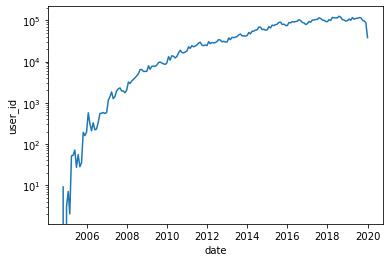

In [6]:
question2(df_review)

# A randomized experiment

We now want to extract our experimental data from our large data set. Given the random assignment we are going to compare the treated group to simply everyone else in the data. In this exercice, we are interested in the effect of the policy overt time. We are then going to look at the log number of reviews in each of the month around the introduction of the interface change.

I would like for you to do the following:
 1. extract the list of treated individuals from the provided file
 2. attach the treated status to each observation in the data, you can use `eval` or a merge.
 3. plot the log number of reviews per month in the treatment and in the control group. 
 4. given that the treatment status was randomized, the picture should look a bit surpising, please explain what you would have expected to see.
 
Here is the plot I get, try to reproduce it as closely as possible.

In [7]:
#Answer to question 3 

def question3(df_r, file_t):
    '''
    Plot the log number of reviews per month in the treatment and in the control group. 
    '''
    
    # Extract the list of individuals from the JSON file_treatment
    randomly_treated_group = pd.read_json(file_t, typ='frame', lines=True)
    
    # Add the column name as user_id
    randomly_treated_group = randomly_treated_group.rename(columns={0:'treated_user_id'})
    
    # User the inner join to combine two DataFrames based on a join key
    df_local = df_r.merge(randomly_treated_group, how='outer', left_on='user_id', right_on='treated_user_id')
    
    # Separate the treated group from the control group
    treatment_group = df_local.loc[df_local.treated_user_id.notnull()]
    control_group = df_local.loc[df_local.treated_user_id.isna()]
     
    # Plot the data for the treated vs. control groups
    
    treatment_pool = treatment_group.set_index('date').resample('M').count()
    treatment_pool2 = treatment_pool[treatment_pool['user_id']!=0]

    control_pool = control_group.set_index('date').resample('M').count()
    control_pool2 = control_pool[control_pool['user_id']!=0]
    
    plt.plot(control_pool2['user_id'])
    plt.plot(treatment_pool2['user_id'])

    plt.legend(['False', 'True'], title = 'Treated')
    plt.ylabel('review_id')
    plt.xlabel('date')
    plt.yscale('log')
    plt.show()
    
    return randomly_treated_group, df_local

#### Question 3, part 4: explain what you would have expected to see

Looking at the output of the log number of reviews per month in the treatment and in the control group, we can see that for the treatment group, the log number of reviews declines after 2010.
Comparatively, the control group follows an upward trend line in the same time period.
Given that our selection of users was randomized, analysis output is not in conformity with the common trend assumption, which specifies that a parallel trend for the treatment group that would occur in absence of treatment. This suggests that our control group is not the best comparison for our treatment group.

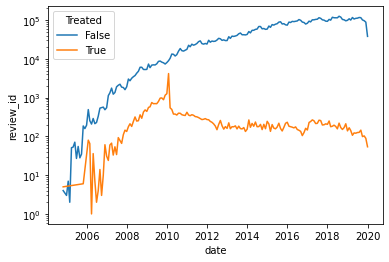

In [8]:
# df_local returns all entries with a column treated, user_treat is the list of treated user_id
user_treat, df_local = question3(df_review, file_treatment)

# Changing comparison group

We clearly created some issues in the way we analyzed our sample. In this section we are going to use a more comparable group. 

 1. using the criteria descriged in the intro, construct the original set of users from which the treatment group was selected. 
 - extracts the users from the this group wich are not in the treatment group, this will be our control group.
 - using this new control group, plot the log number of reviews in each **quarter** for treatment and control
 - finally plot the outcome in difference, however make sure to remove the log-number of individual from each group to plot the log number of reviews per user, overwise your intercept won't be around 0!
 
Here are the plots I got: 

In [9]:
# Answer to question 4

def question4(df_l, user_t):
    '''
    Plot quarterly log reviews of treatment group and control group of users who posted
    one review in January 2010 who are not in the treatment group. 
    Plot the outcome in differneces. 
    '''
    
    # Construct the original set of users from which the treatment group was selected,
    # specifically users who posted a review in the month of January 2010.
    
    group = df_l.loc[(df_l.date >= '2010-01-01') & (df_l.date < '2010-02-01')]
    treatment_group = group.loc[group.treated_user_id.notnull()]
    treatment_group = treatment_group.drop(columns=['review_id', 'date', 'treated_user_id'])

    # Sort into control and treatment group within this pool
    control_group = group.loc[group.treated_user_id.isna()]
    control_group = control_group.drop(columns=['review_id', 'date', 'treated_user_id'])        
    
    # Track control and treatment users across dataset
    control_pool = df_l[df_l['user_id'].isin(control_group['user_id'])]
    treatment_pool = df_l[df_l['user_id'].isin(treatment_group['user_id'])]
    
    # Plot the data for the treated vs. control groups
    treatment_pool2 = treatment_pool.set_index('date').resample('Q').count()
    treatment_pool2 = treatment_pool2[treatment_pool2['user_id']!=0]

    control_pool2 = control_pool.set_index('date').resample('Q').count()
    control_pool2 = control_pool2[control_pool2['user_id']!=0]
    
    plt.figure()
    plt.plot(control_pool2['user_id'])
    plt.plot(treatment_pool2['user_id'])
    
    plt.ylabel('review_id')
    plt.xlabel('date')
    plt.yscale('log')
    plt.legend(['False', 'True'], title = 'Treated')
    plt.show()
    
    # Plot outcome in differences 
    
    num_control = control_group['user_id'].nunique()
    num_treatment = treatment_group['user_id'].nunique()
    
    diff_treatment = np.log(treatment_pool2['user_id']) - np.log(num_treatment)
    diff_control = np.log(control_pool2['user_id']) - np.log(num_control)

    diff = diff_treatment - diff_control
    diff = diff[10:]
    
    plt.figure()
    plt.plot(diff)
    plt.ylabel('diff')
    plt.xlabel('date')   
    plt.show()
    
    return df_l


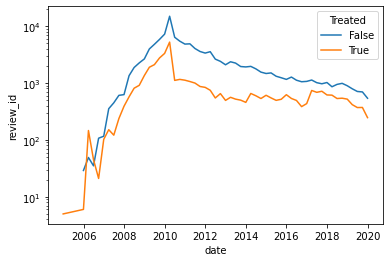

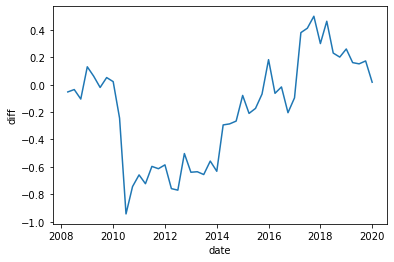

In [10]:
df_local = question4(df_local, user_treat)

# Using activity per user and time

We are now interested in conducting some inference on our results. However we remember that the level of randomization is the `user` not the `review`. Hence we now decide to construct observation at the `(user,year)` level. We decide to use years instead of months because the probability at the month level is too low.

 1. Construct a DataFrame with all `(user,year)` pairs and a column called `post` which is equal to 1 if the user posted in that month and 0 if he didn't. To construct such dataframe I used the `pd.MultiIndex.from_product` function, but one could use a `merge` instead.
 2. Use this newly created DataFrame to plot the level for each group and each, and to plot the difference between the two.
 
Here are the plots I constructed:

In [11]:
# Answer to question 5

def question5(df_l, user_t):
    ''' 
    Plot levels and differences at user level of randomization.
    Return dataframe with all (user, year) pairs in control and treatment groups. 
    '''

    #5.1: construct a DataFrame with (user,year) pairs 
    df_user = df_l.copy()
    
    # Set the DataFrame date column to year and drop treatment column
    df_user['year'] = df_user['date'].dt.year
    df_user=df_user.drop(columns=['date','treated_user_id'])
   
    # Aggregate by user_id and year 
    df_user = df_user.groupby(['user_id','year']).count()
    
    # Create a MultiIndex using the df_local DataFrame
    years = [i for i in range(2004, 2020)]
    user_index = pd.MultiIndex.from_product([df_l['user_id'].unique(), years], names=['user_id', 'year']).to_frame(index=False)
    
    # Merge and using the newly created index
    df_pairs = user_index.merge(df_user, how='left', left_on=['user_id','year'], right_on=['user_id', 'year'])
    
    # Identify and mark the treated users
    df_pairs['treated'] = df_pairs['user_id'].isin(user_t['treated_user_id'])

    # Identify and mark the control group from January 2010 pool
    group = df_l.loc[(df_l.date >= '2010-01-01') & (df_l.date < '2010-02-01')]
    control_group = group.loc[group.treated_user_id.isna()]
    control_group = control_group.drop(columns=['review_id', 'date', 'treated_user_id'])        
    df_pairs['control'] = df_pairs['user_id'].isin(control_group['user_id'])

    # Filter dataframe for users in treatment or control group
    df_pairs = df_pairs[df_pairs[['treated','control']].any(1)]

    # Fill NaN review values with 0 and add the post column with True or False
    values = {'review_id': 0}
    df_pairs=df_pairs.fillna(value=values)
    df_pairs['post'] = (df_pairs['review_id']>=1)
    
    # Re-organize the columns to match solution dataframe
    df_pairs['year'] = pd.to_datetime(df_pairs['year'], format='%Y')
    df_pairs = df_pairs[['user_id','year','review_id','post', 'treated']]
    
    #5.2a: plot the level for each group 
    treatment_pool = df_pairs[df_pairs['treated']==True]
    control_pool = df_pairs[df_pairs['treated']==False]

    treatment_pool2 = treatment_pool.set_index('year').resample('Y').mean()
    control_pool2 = control_pool.set_index('year').resample('Y').mean()

    plt.figure()
    plt.plot(control_pool2['post'])
    plt.plot(treatment_pool2['post'])
    
    plt.ylabel('active')
    plt.xlabel('date')
    plt.axvline(x = '2010-01-01', linestyle = ":")
    plt.legend(['False', 'True'], title = 'Treated')
    plt.show()

    #5.2b: plot outcome in differences
    
    diff = treatment_pool2['post'] - control_pool2['post']

    plt.figure()
    plt.plot(diff)
    plt.ylabel('diff')
    plt.xlabel('date')
    plt.axhline(y = 0, linestyle = ':')
    plt.show()

    return df_pairs

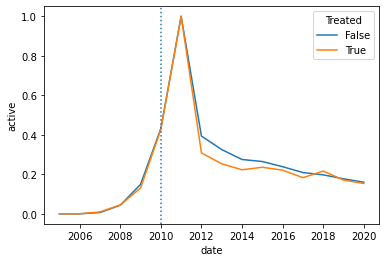

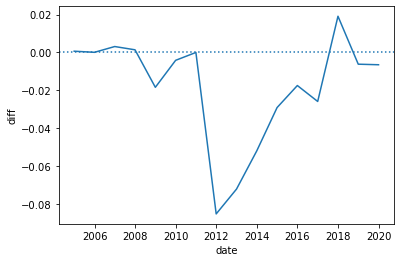

In [12]:
df_local_user = question5(df_local,user_treat)

In [13]:
df_local_user

,user_id,year,review_id,post,treated
144,jOERvhmK6_lo_XGUBPws_w,2004-01-01,0.0,False,False
145,jOERvhmK6_lo_XGUBPws_w,2005-01-01,0.0,False,False
146,jOERvhmK6_lo_XGUBPws_w,2006-01-01,0.0,False,False
147,jOERvhmK6_lo_XGUBPws_w,2007-01-01,0.0,False,False
148,jOERvhmK6_lo_XGUBPws_w,2008-01-01,0.0,False,False
...,...,...,...,...,...
31451787,puuEt2tfjycYXPUuBx-9ag,2015-01-01,0.0,False,False
31451788,puuEt2tfjycYXPUuBx-9ag,2016-01-01,0.0,False,False
31451789,puuEt2tfjycYXPUuBx-9ag,2017-01-01,0.0,False,False
31451790,puuEt2tfjycYXPUuBx-9ag,2018-01-01,0.0,False,False


# Construct confidence inference

In this final question our goal is to add some inference to our plot. We are going to simply use the asymptotic variance implied by the OLS formula. Do the following:

 1. create a function that will take a dataframe containing the columns `post` and `treat` and returns the OLS estimate of `post` on `treat` together with the estimate of the variance of that estimate (Remember that in this simple case $\hat{\beta} = cov(y,x)/var(x)$ and that teh variance is $\sigma^2_\epsilon/(n \cdot var(x))$. Return the results as a new dataframe with one row and 2 columns.
 2. apply your function to your data from question 4 within eave `year` (you can do that using `pd.Grouper(freq='Y',key='date')` within a `groupby` and use the `apply` method.
 3. use your grouped results to plot the mean together with their 95% asymptotic conf interval
 4. comment on the results, in particular on date before the start of the experiment.
 
I report the plot I got:

In [15]:
# Answer to question 6

# Question 6, part 1: create function to return OLS estimate

def ols_estimate(df_local_user):
    # Assign x and y columns
    x = df_local_user['treated']
    y = df_local_user['post']
    
    # Find cov(x, y) and var(x) to calculate beta_hat
    cov_yx = np.cov(y, x)[0, 1]
    var_x = np.cov(y, x)[1,1]
    beta_hat = cov_yx/var_x
    
    # Calculate variance of OLS estimator 
    n = len(df_local_user)
    errors = y - beta_hat*x
    error_var = (np.std(errors))** 2
    var = error_var/(n* var_x)
    
    # Create dataframe with beta_hat and variance of beta_hat
    ols_est = pd.DataFrame([[beta_hat, var]], columns=['beta_hat', 'var'])
    
    return ols_est

ols_estimate(df_local_user)

,beta_hat,var
0,-0.018286,0.000011


In [16]:
# Question 6, part 2 and 3: apply function to data and plot with error bars

def question6(df_l_user): 
    
    # Apply ols estimate function using pd.Grouper withing groupby
    df_ols = df_l_user.groupby(pd.Grouper(freq='Y',key='year')).apply(ols_estimate)
    
    # Find standard errors for error bars
    errors = 1.96*np.sqrt(df_ols['var'])
    
    #Plot graph with error bars
    df_ols = df_ols.reset_index()
    plt.errorbar(df_ols['year'], df_ols['beta_hat'], yerr = errors)
    plt.axhline(0, linestyle = ':')
    plt.show()


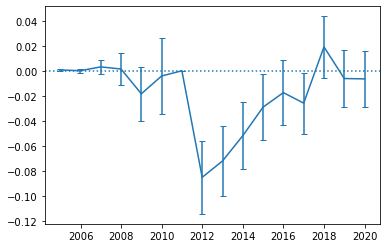

In [17]:
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 3})
question6(df_local_user)

#### Question 6, part 4: comment on the results

Before the start of the experiment, it looks like the difference in posting between the treatment and control groups is close to 0 (or has a 95% confidence interval that includes 0). After 2010, when the treatment was assigned, the difference seems to drop a fair amount, indicating the treatment may have been effective. Around 2017-2018, however, the difference closed bock to around 0, which means the effect of the treatment might have only been temporary. 

Quick note - question 6.2 asked us to apply our function to our data from question 4, but only question 5 had data with the 'treated' and 'post' columns. We used our data from 5 instead and the graph matches the one shown from the solution. 

Congrats, you are done!